# Studying glass classification

I'm trying to learn a bit more on 2 topics:

1. spotting and correcting skewed data
2. tuning the Random Forest Classifier parameters to achieve better results

## The data
This is the list of all the fields.

* Id number: 1 to 214 (removed from CSV file)
* RI: refractive index
* Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
* Mg: Magnesium
* Al: Aluminum
* Si: Silicon
* K: Potassium
* Ca: Calcium
* Ba: Barium
* Fe: Iron
* Type of glass: (class attribute)
  *  1 building_windows_float_processed
  * 2 building_windows_non_float_processed
  * 3 vehicle_windows_float_processed
  * 4 vehicle_windows_non_float_processed (none in this database)
  * 5 containers
  * 6 tableware
  * 7 headlamps

In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Loading dataset and showing some records

In [34]:
#df = pd.read_csv('../input/glass.csv')
df = pd.read_csv('glass.csv')

df.sample(5)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
113,1.51892,13.46,3.83,1.26,72.55,0.57,8.21,0.0,0.14,2
94,1.51629,12.71,3.33,1.49,73.28,0.67,8.24,0.0,0.00,2
88,1.51618,13.01,3.50,1.48,72.89,0.60,8.12,0.0,0.00,2
160,1.51832,13.33,3.34,1.54,72.14,0.56,8.99,0.0,0.00,3
166,1.52151,11.03,1.71,1.56,73.44,0.58,11.62,0.0,0.00,5


## Unbalanced classes

The classes in this dataset are not equally represented. Classes `3`, `5` and `6` are really poor and past analyses show that the algorithms struggle to classify data for them.

In [35]:
df.groupby(by='Type').count()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
Type,,,,,,,,,
1,70,70,70,70,70,70,70,70,70
2,76,76,76,76,76,76,76,76,76
3,17,17,17,17,17,17,17,17,17
5,13,13,13,13,13,13,13,13,13
6,9,9,9,9,9,9,9,9,9
7,29,29,29,29,29,29,29,29,29


I try to find some common values in records for those classes. The goal is to duplicate data including some variation in order to "reinforce" the classification.

### Past results
Before doing it, I note here the past performances to see if there's an improvement.

This is the correlation between the features and the class:
* Mg      0.744993
* Al      0.598829
* Ba      0.575161
* Na      0.502898
* Fe      0.188278
* RI      0.164237
* Si      0.151565
* K       0.010054
* Ca      0.000952

This is the best estimator perf for a Random Forest:
```
0.7890625
{'n_estimators': 100, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}
```

And this is the cross-validation score:
`Score: 0.756`

Let's go.


### Generating random samples

I create some useful function that helps me create new samples for the "poor" classes using their mean and standard deviation values and setting to 0 a set of labels

In [36]:

# generate a -1 or +1 at random to add or subtract a random value from the mean
def random_sign():
    return [-1 if np.random.random()<.5 else 1]

# generate a new fake sample based on the passed means and standard deviations arrays,
# setting the passed Type value and the passed labels at zero
def gen_sample(mm, ss, type, labels_at_zero=[]):
    ix = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
    new = np.abs(mm + (ss * np.random.random(len(ix)) * random_sign() ))
    for l in labels_at_zero:
        new[l] = 0
    new['Type'] = type
    return new



In [37]:
# Class 6
# Selecting the 'mean' and 'std' columns from the describe() to generate random values for the class
means = df[df['Type']==6].describe().loc['mean',:]
stds = df[df['Type']==6].describe().loc['std',:]

# this was the full table, I took only the second and third row
df[df['Type']==6].describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.0,9.0,9.0
mean,1.517456,14.646667,1.305556,1.366667,73.206667,0.0,9.356667,0.0,0.0,6.0
std,0.003116,1.084020,1.097134,0.571861,1.079467,0.0,1.449948,0.0,0.0,0.0
min,1.511150,13.790000,0.000000,0.340000,72.370000,0.0,6.650000,0.0,0.0,6.0
25%,1.518290,14.090000,0.000000,1.190000,72.500000,0.0,9.260000,0.0,0.0,6.0
50%,1.518880,14.400000,1.740000,1.560000,72.740000,0.0,9.570000,0.0,0.0,6.0
75%,1.519160,14.560000,2.240000,1.660000,73.480000,0.0,9.950000,0.0,0.0,6.0
max,1.519690,17.380000,2.410000,2.090000,75.410000,0.0,11.220000,0.0,0.0,6.0


In [38]:
# using a temp value
dfnew = df
for i in range(0, 15):
    dfnew = dfnew.append(gen_sample(means, stds, 6, ['Ba', 'Fe', 'K']), ignore_index=True)

In [39]:
# Let's check what happened
dfnew[dfnew['Type']==6].describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.0,24.000000,24.0,24.0,24.0
mean,1.517456,14.678591,1.361889,1.402145,73.266004,0.0,9.312509,0.0,0.0,6.0
std,0.002102,0.792984,0.788734,0.449066,0.876232,0.0,1.100887,0.0,0.0,0.0
min,1.511150,13.640782,0.000000,0.340000,72.138512,0.0,6.650000,0.0,0.0,6.0
25%,1.516517,14.135000,0.774246,1.155295,72.571538,0.0,8.408434,0.0,0.0,6.0
50%,1.518108,14.520670,1.494333,1.532534,72.856573,0.0,9.585623,0.0,0.0,6.0
75%,1.518922,14.995445,2.153026,1.697023,73.966663,0.0,9.952900,0.0,0.0,6.0
max,1.519690,17.380000,2.410000,2.090000,75.410000,0.0,11.220000,0.0,0.0,6.0


Count raised to 19, so correctly +10. Standard deviation obviously decreased because I was adding random values inside the stddev range. Maybe this helps prediction too but I feel I'm corrupting the data a bit more than I wanted.

Now I do the same for the rest of the classes. BTW, I already checked that classes 3 and 5 do not have blank features.

In [40]:
# Class 3
# Selecting the 'mean' and 'std' columns from the describe() to generate random values for the class
means = df[df['Type']==3].describe().loc['mean',:]
stds = df[df['Type']==3].describe().loc['std',:]

for i in range(0, 20):
    dfnew = dfnew.append(gen_sample(means, stds, 3, []), ignore_index=True)

# Class 5
# Selecting the 'mean' and 'std' columns from the describe() to generate random values for the class
means = df[df['Type']==5].describe().loc['mean',:]
stds = df[df['Type']==5].describe().loc['std',:]
for i in range(0, 8):
    dfnew = dfnew.append(gen_sample(means, stds, 5, []), ignore_index=True)


### A final check on the data

In [41]:
dfnew.groupby(by='Type').count()


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
Type,,,,,,,,,
1.0,70,70,70,70,70,70,70,70,70
2.0,76,76,76,76,76,76,76,76,76
3.0,37,37,37,37,37,37,37,37,37
5.0,21,21,21,21,21,21,21,21,21
6.0,24,24,24,24,24,24,24,24,24
7.0,29,29,29,29,29,29,29,29,29


In [42]:
df = dfnew

### X and Y
Dropping the class (`Type` column) from the X set and moving it in the Y set

In [43]:
X = df.drop(['Type'], axis=1)
Y = df['Type']

How the features influence the classification

In [44]:
df.corr()['Type'].abs().sort_values(ascending=False)

Type    1.000000
Mg      0.746624
Al      0.541915
Na      0.515625
Ba      0.499839
Fe      0.204644
Si      0.177599
RI      0.174707
K       0.038901
Ca      0.036938
Name: Type, dtype: float64

### Calculating data skewness and possibly unskewing

/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:905: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1877: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1878: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1875: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


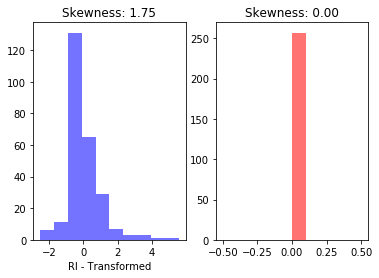

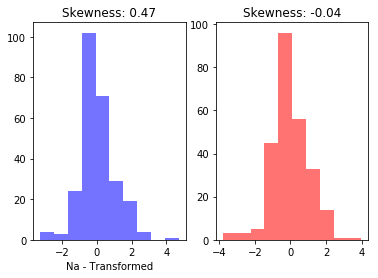

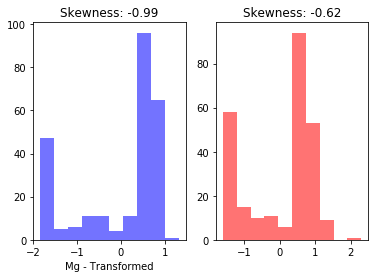

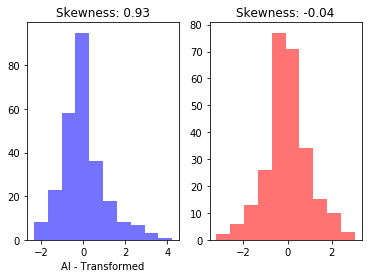

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:152: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


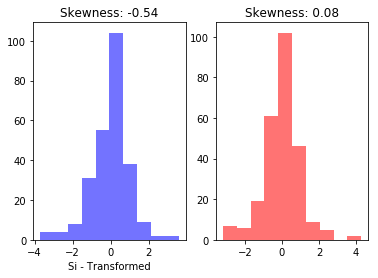

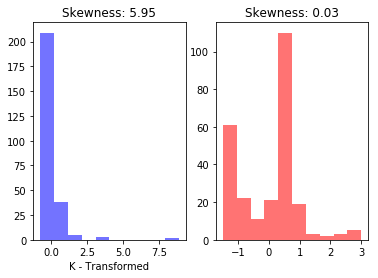

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:169: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


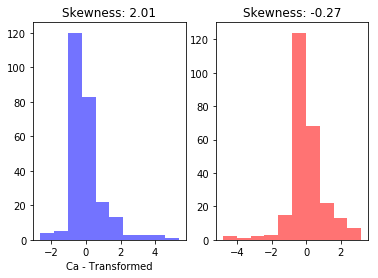

/opt/conda/lib/python3.6/site-packages/scipy/optimize/optimize.py:2207: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


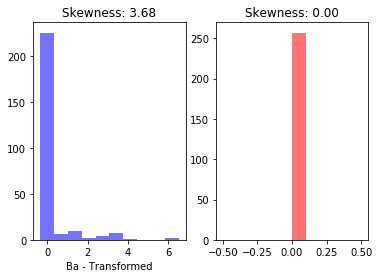

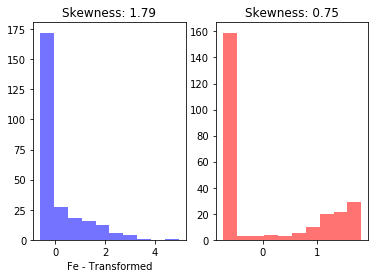

In [45]:
import matplotlib.pylab as plt
from sklearn import preprocessing
from scipy.stats import skew
from scipy.stats import boxcox

# getting features names to loop
classes = X.columns.values

# This will contain the unskewed features
X_unsk = pd.DataFrame()

# looping through the 
for c in classes:
    scaled = preprocessing.scale(X[c]) 
    boxcox_scaled = preprocessing.scale(boxcox(X[c] + np.max(np.abs(X[c]) +1) )[0])
    
    # Populating 
    X_unsk[c] = boxcox_scaled
    
    #Next We calculate Skewness using skew in scipy.stats
    skness = skew(scaled)
    boxcox_skness = skew(boxcox_scaled)
    
    #We draw the histograms 
    figure = plt.figure()
    # First the original data shape
    figure.add_subplot(121)   
    plt.hist(scaled,facecolor='blue',alpha=0.55) 
    plt.xlabel(c + " - Transformed") 
    plt.title("Skewness: {0:.2f}".format(skness)) 
    
    # then the unskewed
    figure.add_subplot(122) 
    plt.hist(boxcox_scaled,facecolor='red',alpha=0.55) 
    plt.title("Skewness: {0:.2f}".format(boxcox_skness)) 

    plt.show()

In most cases the BoxCox unskewing is successfully transforming the data

## Hyperparameters

Searching the best parameters for the Random Forest Classifier 

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import math

# Here I use the unskewed dataset
X = X_unsk
X_tr, X_ts, y_tr, y_ts = train_test_split(X, Y, test_size=0.40, random_state=42)

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { "criterion" : ["gini", "entropy"]
              , "min_samples_leaf" : [1, 5, 10]
              , "min_samples_split" : [2, 4, 10, 12, 16]
              , "n_estimators": [100, 125, 200]}
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
gs = gs.fit(X_tr, y_tr)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   47.5s finished


### Score

Printing best score performance and algorithm parameters

In [47]:
print(gs.best_score_)
print(gs.best_params_)

0.772727272727
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 125}


### Training and validation set

Final training with the best hyperparameters found by GridSearchCV

In [48]:
bp = gs.best_params_
rf = RandomForestClassifier( criterion=bp['criterion'], 
                             n_estimators=bp['n_estimators'],
                             min_samples_split=bp['min_samples_split'],
                             min_samples_leaf=bp['min_samples_leaf'],
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

rf.fit(X_tr, y_tr)
pred = rf.predict(X_ts)

score = rf.score(X_ts, y_ts)
print("Score: %.3f" % (score))

Score: 0.670


Works better on the training set but worse on the validation. It looks like the fake data is overfitting the algorithm.

### Features importance
This is the features importances for the algorithm

In [49]:
pd.concat((pd.DataFrame(X.columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
3,Al,0.216273
2,Mg,0.198641
6,Ca,0.155343
1,Na,0.135519
5,K,0.120188
4,Si,0.106123
8,Fe,0.067913
0,RI,0.000000
7,Ba,0.000000


Taking a look at the confusion matrix.

Confusion matrix, without normalization
[[18  6  5  0  0  0]
 [10 17  1  0  1  1]
 [ 5  1  8  0  0  0]
 [ 0  2  0  9  0  0]
 [ 0  0  0  0 10  1]
 [ 0  0  0  0  1  7]]


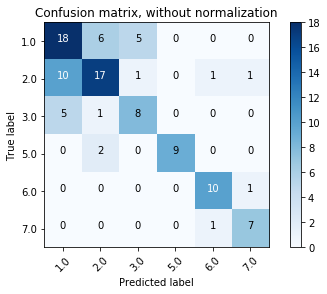

In [50]:
from sklearn.metrics import confusion_matrix
import itertools
#print(y_ts.values)
#print(pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_ts.values, pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.sort(y_ts.unique()), normalize=False,
                      title='Confusion matrix, without normalization')

Classes 3, 4 and 5 are ok now but I corrupted 1 and 2!!

## Trying with XGBoost

As suggested in the comments, I try to compare this Random Forest model with an XGBoost to see how both perform with this dataset.

In [51]:
from xgboost import XGBClassifier

# Here I use the unskewed dataset
X = X_unsk
X_tr, X_ts, y_tr, y_ts = train_test_split(X, Y, test_size=0.4, random_state=42)
xgb = XGBClassifier()

param_grid = { "max_depth" : [5]
              , "learning_rate" : [0.1, 0.125, 0.2]
              , "n_estimators": [50, 100]
              , "reg_lambda": [.01, .1, .5]}
gs = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
gs = gs.fit(X_tr, y_tr)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    8.4s finished


In [52]:
print(gs.best_score_)
print(gs.best_params_)

0.772727272727
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'reg_lambda': 0.1}


The score on the TS is a bit worse than the RF even though I tried many parameters combination.

In [53]:
bp = gs.best_params_
xgb = XGBClassifier( max_depth=bp['max_depth'], 
                             n_estimators=bp['n_estimators'],
                             learning_rate=bp['learning_rate'],
                   reg_lambda=bp['reg_lambda'])

xgb.fit(X_tr, y_tr)
pred = xgb.predict(X_ts)

score = xgb.score(X_ts, y_ts)
print("Score: %.3f" % (score))

Score: 0.650


XGBoost instead has gone better.

The feature importance matrix is slightly different from the RF's one.

In [54]:
pd.concat((pd.DataFrame(X.columns, columns = ['variable']), 
           pd.DataFrame(xgb.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
2,Mg,0.222222
3,Al,0.165165
1,Na,0.157658
6,Ca,0.154655
4,Si,0.133634
5,K,0.101351
8,Fe,0.065315
0,RI,0.000000
7,Ba,0.000000


Confusion matrix, without normalization
[[20  4  5  0  0  0]
 [ 7 18  3  1  0  1]
 [ 6  1  7  0  0  0]
 [ 0  4  0  7  0  0]
 [ 0  0  0  0  8  3]
 [ 0  0  0  0  1  7]]


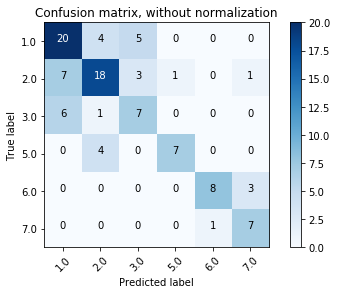

In [55]:
cnf_matrix = confusion_matrix(y_ts.values, pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.sort(y_ts.unique()), normalize=False,
                      title='Confusion matrix, without normalization')

Again the issue here are features 1 and 2 that worked a lot better before the fake data was introduced.

## Conclusions

OLD COMMENT:
> I'm really a novice in ML but I'm trying to apply all the interesting stuff I find in many awesome Kaggle kernels and discussions in order to slowly learn how work with data.
> In this case I've learned a bit more about feature skewing, Random Forest parameters tuning and I did some experiment with XGBoost but the kernel is really far from defining a decent classifier for the glass classification problem. Maybe I need to study more the dataset and to try other classifiers.

NEW COMMENT:
I tried to fix the poor performance of this small dataset adding fake values, similar to the existing ones, for the less represented classes. It has not worked as I expected, maybe I added too much data or maybe someone has a better explanation out there!

Anyway, any advice is welcome!

In [92]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
print(skf.get_n_splits(X, Y))
print(skf) 
print(X.shape)
for train, test in skf.split(X, Y):
    print(np.max(train))
    #X.ix[256]
    X_train, X_test = X.ix[train], X.ix[test]
    Y_train, Y_test = Y.ix[train], Y.ix[test]

    xgb.fit(X_train,Y_train)
    print("score on training set", xgb.score(X_train,Y_train))
    print("score on validation set", xgb.score(X_test,Y_test))

    


3
StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
(257, 9)
256
score on training set 1.0
score on validation set 0.556818181818
256
score on training set 1.0
score on validation set 0.611764705882
249
score on training set 1.0
score on validation set 0.642857142857
